In [16]:
from jax import config

config.update("jax_enable_x64", True)


import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2"

import numpy as np
import jax.numpy as jnp
import pyssht as ssht 

from jax import jit, device_put, pmap
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

from s2fft import samples
from s2fft.jax_transforms import spin_spherical
from s2fft.wigner.price_mcewen import generate_precomputes, generate_precomputes_jax

import warnings
warnings.simplefilter("ignore")

gpu


In [17]:
# Define parameters of transform
L_approx = 64
L = 3*int(L_approx/3)
print(f"L = {L}")
spin = 1
reality = False

# Define iso-latitudinal sampling scheme
sampling = "mw"
ntheta = samples.ntheta(L, sampling)
nphi = samples.nphi_equiang(L, sampling)

# Generate a random signal
f = np.random.randn(ntheta,nphi) + 1j*np.random.randn(ntheta,nphi)
f = f.astype(np.complex128)

# Compute the bandlimit harmonic coefficients
flm_1d = ssht.forward(f, L, spin, Method=sampling.upper())
flm = samples.flm_1d_to_2d(flm_1d, L)
flm[:abs(spin)] = 0
flm_1d = samples.flm_2d_to_1d(flm, L)

L = 63


In [18]:
f_ssht = ssht.inverse(flm_1d, L, spin, Method=sampling.upper())
# %timeit ssht.inverse(flm_1d, L, spin, Method=sampling.upper())

In [19]:
# Generate O(L^2) memory precompute
precomps = generate_precomputes(L, spin, sampling)

f_jax = spin_spherical.inverse_numpy(flm, L, spin, None, sampling, reality, precomps)

In [20]:
# # Generate O(L^2) memory precompute
# precomps = generate_precomputes_jax(L, spin, sampling)

# flm_jax = device_put(flm)
# f_jax = spin_spherical.inverse_jax(flm_jax, L, spin, None, sampling, reality, precomps, spmd=False)
# %timeit spin_spherical.inverse_jax(flm_jax, L, spin, None, sampling, reality, precomps, spmd=False)

In [21]:
# # Generate O(L^2) memory precompute
# precomps = generate_precomputes_jax(L, spin, sampling)

# flm_jax = device_put(flm)
# f_jax_spmd = spin_spherical.inverse_jax(flm_jax, L, spin, None, sampling, reality, precomps, spmd=True)
# %timeit spin_spherical.inverse_jax(flm_jax, L, spin, None, sampling, reality, precomps, spmd=True)

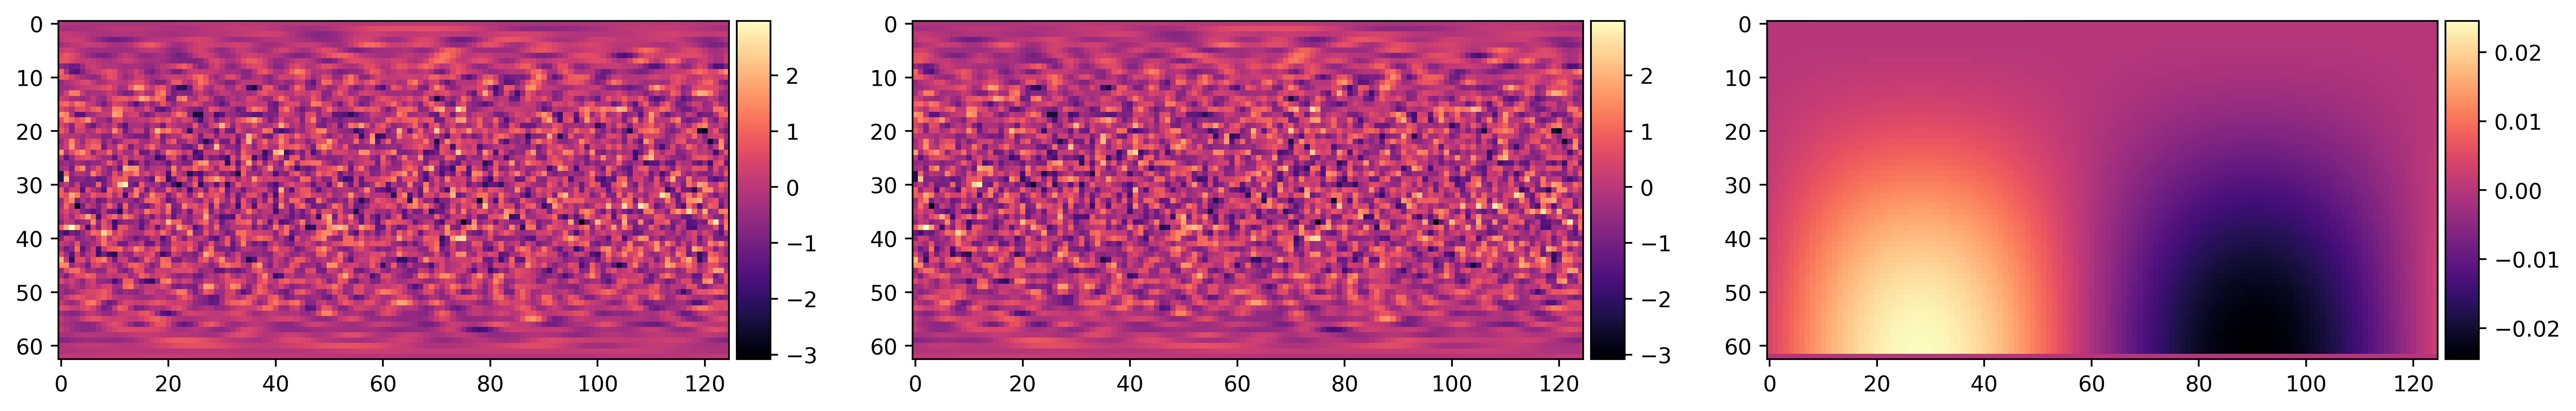

In [25]:
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

mx, mn = np.nanmax(np.real(f_ssht)),np.nanmin(np.real(f_ssht))
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.dpi"] = 500

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
im1 = ax1.imshow(np.real(f_ssht), vmax=mx, vmin=mn, cmap='magma')
im2 = ax2.imshow(np.real(f_jax), vmax=mx, vmin=mn, cmap='magma')
im3 = ax3.imshow(np.real(f_ssht)-np.real(f_jax), cmap='magma')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()

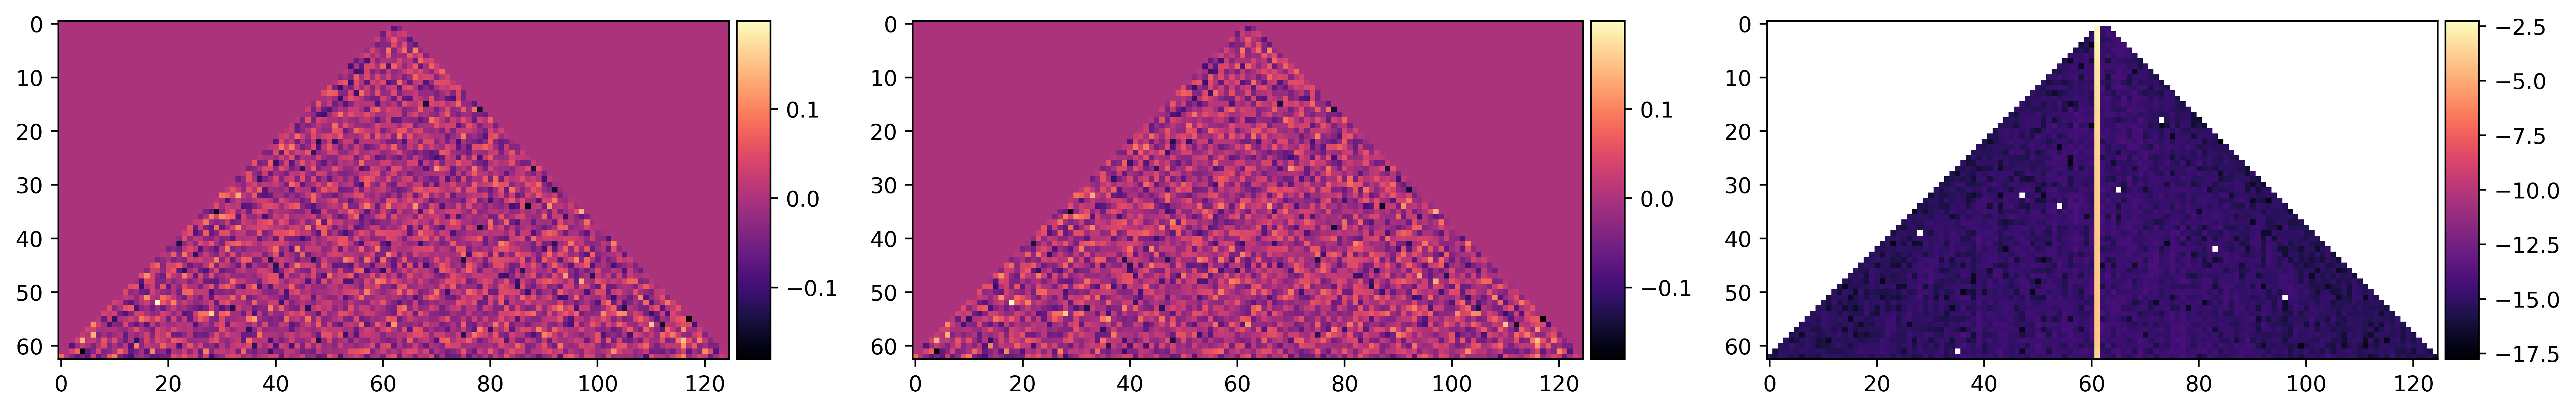

In [26]:
flm_1 = samples.flm_1d_to_2d(ssht.forward(f_ssht, L, spin), L)
flm_2 = samples.flm_1d_to_2d(ssht.forward(f_jax, L, spin), L)

mx, mn = np.nanmax(np.real(flm_1)),np.nanmin(np.real(flm_2))


fig, (ax1,ax2,ax3) = plt.subplots(1,3)
im1 = ax1.imshow(np.real(flm_1), vmax=mx, vmin=mn, cmap='magma')
im2 = ax2.imshow(np.real(flm_2), vmax=mx, vmin=mn, cmap='magma')
im3 = ax3.imshow(np.log10(abs(np.real(flm_1)-np.real(flm_2))), cmap='magma')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()